**Imports**


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

tfds.disable_progress_bar() 


Data set


In [ ]:
splits = ['train', 'test', 'test'] 

(raw_train_data, raw_test_data, raw_validation_data), info = tfds.load("stanford_dogs", split= splits, with_info= True, as_supervised= True)


In [ ]:
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
print(num_examples)
print(num_classes)
print(info.features)

12000
120
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})




*   Visulize the Dataset


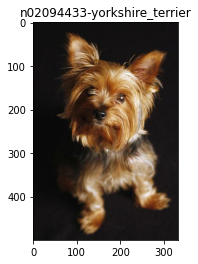

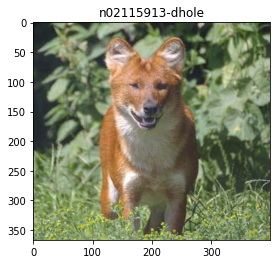

In [ ]:
get_label_name = info.features['label'].int2str
for image, label in raw_train_data.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))



* Create list of labels



In [ ]:
BATCH_SIZE = 32

In [ ]:
IMAGE_SIZE = 224 # using 224 x 224 because that's what the pretrained mobile net model uses 
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) # use a 224 x 224 image with rgb for the color data

In [ ]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0 # normlize data
  return image, label 

In [103]:
train_batches = raw_train_data.shuffle(1000).map(format_image).batch(BATCH_SIZE)
test_batches = raw_test_data.map(format_image).batch(1)
validation_batches = raw_validation_data.map(format_image).batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [ ]:
do_fine_tuning = False

In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape= INPUT_SHAPE, 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)



In [ ]:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 120)               153720    
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [76]:
history = model.fit(train_batches, epochs=5, validation_data=validation_batches)

Epoch 1/5
375/375 [==============================] - 671s 2s/step - loss: 1.2419 - accuracy: 0.6926 - val_loss: 0.6254 - val_accuracy: 0.8119
Epoch 2/5
375/375 [==============================] - 671s 2s/step - loss: 0.3966 - accuracy: 0.8837 - val_loss: 0.5643 - val_accuracy: 0.8226
Epoch 3/5
375/375 [==============================] - 670s 2s/step - loss: 0.2529 - accuracy: 0.9345 - val_loss: 0.5231 - val_accuracy: 0.8355
Epoch 4/5
375/375 [==============================] - 670s 2s/step - loss: 0.1708 - accuracy: 0.9631 - val_loss: 0.5350 - val_accuracy: 0.8314
Epoch 5/5
375/375 [==============================] - 669s 2s/step - loss: 0.1231 - accuracy: 0.9775 - val_loss: 0.5223 - val_accuracy: 0.8354


### Save the labels to a file


In [88]:
import re
label_names = info.features['label'].names

for i in range(len(label_names)):
    name = label_names[i]
    name = re.sub("^n\d+-", "", name)
    name = re.sub("_", " ", name)
    label_names[i] = name + '\n'

with open("labels.txt", 'wt') as labels_file:
    labels_file.writelines(label_names)

['n02085620-chihuahua', 'n02085782-japanese_spaniel', 'n02085936-maltese_dog', 'n02086079-pekinese', 'n02086240-shih-tzu', 'n02086646-blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-rhodesian_ridgeback', 'n02088094-afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-walker_hound', 'n02089973-english_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-irish_wolfhound', 'n02091032-italian_greyhound', 'n02091134-whippet', 'n02091244-ibizan_hound', 'n02091467-norwegian_elkhound', 'n02091635-otterhound', 'n02091831-saluki', 'n02092002-scottish_deerhound', 'n02092339-weimaraner', 'n02093256-staffordshire_bullterrier', 'n02093428-american_staffordshire_terrier', 'n02093647-bedlington_terrier', 'n02093754-border_terrier', 'n02093859-kerry_blue_terrier', 'n02093991-irish_terrier', 'n02094114-norfolk_terrier', 'n02094258-norwich_terrier', 'n02094433-yorkshire_t


### Optional manually test the model using an image of a dog from the internet



In [90]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  x = image.img_to_array(img) 
  x = x / 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=512)
  index = np.argmax(classes)
  print("The image is: " + label_names[index])


Saving download.jpeg to download (2).jpeg
The iamge is: saint bernard



### Export the model to tflite

In [93]:
DOGS_SAVED_MODEL = 'dog_detector_model'
tf.saved_model.save(model, DOGS_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: dog_detector_model/assets


INFO:tensorflow:Assets written to: dog_detector_model/assets


/bin/bash: -s: command not found


In [96]:
converter = tf.lite.TFLiteConverter.from_saved_model(DOGS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert() 
tflite_model_file = 'dog_detector_model.tflite'

with open(tflite_model_file, 'wb') as file:
  file.write(tflite_model)


### Test the TFLite Model Using the Python Interpreter

In [126]:
from tqdm import tqdm

interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(20)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

20it [00:01, 15.86it/s]


In [127]:
# visulize the results make sure they work using the tensorflow lite interpreter. 
# this part of the code came from the tensorflow lite course on coursera.
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(label_names[predicted_label],
                                         100*np.max(predictions_array),
                                         label_names[true_label]), color=color)


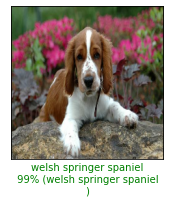

In [164]:
#@title Visualize the outputs { run: "auto" }
index = 0 #@param {type:"slider", min:0, max:19, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

### Download the tflite file

In [162]:
try:
    from google.colab import files
    files.download(tflite_model_file)
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>